# One-shot learning

**Building a One-shot Learning Network with PyTorch**   
Ta-Ying Cheng

https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a

In [5]:
import os
import time
import random
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from PIL import Image

## Dane

In [6]:
omniglot = datasets.Omniglot(root="./data", download=True)

Files already downloaded and verified


In [7]:
omniglot_test = datasets.Omniglot(root="./data", background=False, download=True)

Files already downloaded and verified


0


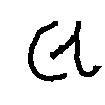

In [8]:
img, label = omniglot[0]
print(label)
img

0


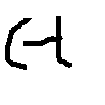

In [9]:
img, label = omniglot[10]
print(label)
img

5


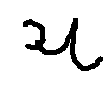

In [10]:
img, label = omniglot[100]
print(label)
img

In [11]:
os.listdir("./data/omniglot-py/images_background/")

['Gujarati',
 'Korean',
 'Arcadian',
 'Malay_(Jawi_-_Arabic)',
 'Grantha',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Balinese',
 '.DS_Store',
 'Futurama',
 'N_Ko',
 'Burmese_(Myanmar)',
 'Anglo-Saxon_Futhorc',
 'Mkhedruli_(Georgian)',
 'Latin',
 'Braille',
 'Sanskrit',
 'Japanese_(hiragana)',
 'Tagalog',
 'Greek',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(katakana)',
 'Early_Aramaic',
 'Hebrew',
 'Tifinagh',
 'Asomtavruli_(Georgian)',
 'Armenian',
 'Syriac_(Estrangelo)',
 'Alphabet_of_the_Magi',
 'Cyrillic',
 'Bengali',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)']

In [12]:
os.listdir("./data/omniglot-py/images_evaluation/")

['Oriya',
 'ULOG',
 'Tengwar',
 '.DS_Store',
 'Malayalam',
 'Atlantean',
 'Keble',
 'Manipuri',
 'Gurmukhi',
 'Tibetan',
 'Aurek-Besh',
 'Ge_ez',
 'Angelic',
 'Old_Church_Slavonic_(Cyrillic)',
 'Kannada',
 'Avesta',
 'Mongolian',
 'Syriac_(Serto)',
 'Atemayar_Qelisayer',
 'Sylheti',
 'Glagolitic']

In [13]:
from omniglot import OmniglotDataset

In [ ]:
class OmniglotDataset(Dataset):
    def __init__(self, root_dir, set_size, transform=None):
        self.root_dir = root_dir
        self.categories = [[folder, [subfolder for subfolder in os.listdir(root_dir + folder) 
                                     if not subfolder.startswith(".")]]
                           for folder in os.listdir(root_dir) 
                           if not folder.startswith(".")]
        self.transform = transform
        self.set_size = set_size
    def __len__(self):
        return self.set_size
    def __getitem__(self, idx):
        ...

In [ ]:
    ...
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        if idx % 2 == 0:
            category = random.choice(self.categories)
            character = random.choice(category[1])
            img_dir = f"{self.root_dir}{category[0]}/{character}"
            img1_name = random.choice(os.listdir(img_dir))
            img2_name = random.choice(os.listdir(img_dir))
            img1 = Image.open(f"{img_dir}/{img1_name}")
            img2 = Image.open(f"{img_dir}/{img2_name}")
            label = 1.0
        else:
            category1, category2 = random.choice(self.categories), random.choice(self.categories)
            character1, character2 = random.choice(category1[1]), random.choice(category2[1])
            img_dir1 = f"{self.root_dir}{category1[0]}/{character1}"
            img_dir2 = f"{self.root_dir}{category2[0]}/{character2}"
            img1_name = random.choice(os.listdir(img_dir1))
            img2_name = random.choice(os.listdir(img_dir2))
            while img1_name == img2_name:
                img2_name = random.choice(os.listdir(img_dir2))
            label = 0.0
            img1 = Image.open(f"{img_dir1}/{img1_name}")
            img2 = Image.open(f"{img_dir2}/{img2_name}")
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor([label], dtype=torch.float32)

In [14]:
omniglot_train = OmniglotDataset("./data/omniglot-py/images_background/", 10000)

In [15]:
img1, img2, label = omniglot_train[0]

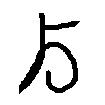

In [16]:
img1

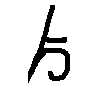

In [17]:
img2

In [18]:
label

tensor([1.])

In [19]:
img1, img2, label = omniglot_train[1]

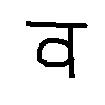

In [20]:
img1

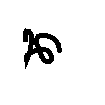

In [21]:
img2

In [22]:
label

tensor([0.])

In [23]:
from omniglot import NWayOmniglotDataset

In [ ]:
class NWayOmniglotDataset(Dataset):
    def __init__(self, root_dir, set_size, num_way, transform=None):
        self.root_dir = root_dir
        self.categories = [[folder, [subfolder for subfolder in os.listdir(root_dir + folder) 
                                     if not subfolder.startswith(".")]]
                           for folder in os.listdir(root_dir) 
                           if not folder.startswith(".")]
        self.set_size = set_size
        self.num_way = num_way
        self.transform = transform
    def __len__(self):
        return self.set_size
    def __getitem__(self, idx):
        ...

In [ ]:
    ...
    def __getitem__(self, idx):
        category = random.choice(self.categories)
        character = random.choice(category[1])
        img_dir = f"{self.root_dir}{category[0]}/{character}"
        img_name = random.choice(os.listdir(img_dir))
        main_img = Image.open(f"{img_dir}/{img_name}")
        if self.transform:
            main_img = self.transform(main_img)
        
        test_set = []
        label = random.randint(0, self.num_way - 1)
        for i in range(self.num_way):
            test_img_dir = img_dir
            test_img_name = ""
            if i == label:
                test_img_name = random.choice(os.listdir(img_dir))
            else:
                test_category = random.choice(self.categories)
                test_character = random.choice(test_category[1])
                test_img_dir = f"{self.root_dir}{test_category[0]}/{test_character}"
                while test_img_dir == img_dir:
                    test_character = random.choice(test_category[1])
                    test_img_dir = f"{self.root_dir}{test_category[0]}/{test_character}"
                test_img_name = random.choice(os.listdir(test_img_dir))
            test_img = Image.open(f"{test_img_dir}/{test_img_name}")
            if self.transform:
                test_img = self.transform(test_img)
            test_set.append(test_img)

        return main_img, test_set, torch.tensor([label], dtype=torch.int16)

In [24]:
omniglot_test = NWayOmniglotDataset("./data/omniglot-py/images_background/", 2000, 20)

In [25]:
img, img_set, label = omniglot_test[0]

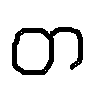

In [26]:
img

In [27]:
img_set

[<PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF2846A3D0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF486027F0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602580>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF486027C0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602880>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF486028E0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF486029D0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602A30>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602790>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602AC0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602AF0>,
 <PIL.PngImagePlugin.PngImageFile image mode=1 size=105x105 at 0x7FDF48602B20>,
 <PIL.PngImagePlugin.PngImageFile image 

In [28]:
label

tensor([0], dtype=torch.int16)

In [29]:
transform = T.Compose([T.ToTensor()])

In [30]:
omniglot_train = OmniglotDataset("./data/omniglot-py/images_background/", 10000, transform)
omniglot_test = NWayOmniglotDataset("./data/omniglot-py/images_evaluation/", 2000, 20, transform)

In [31]:
train_loader = DataLoader(omniglot_train, batch_size=128)
test_loader = DataLoader(omniglot_test, batch_size=1)

## Sieć syjamska

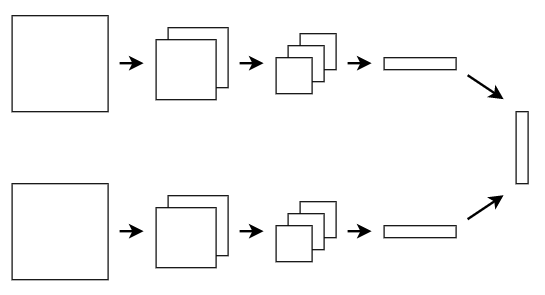

In [32]:
from omniglot import SiameseNet

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv11 = nn.Conv2d(1, 64, 3) 
        self.conv12 = nn.Conv2d(64, 64, 3)  
        self.conv21 = nn.Conv2d(64, 128, 3)
        self.conv22 = nn.Conv2d(128, 128, 3)
        self.conv31 = nn.Conv2d(128, 256, 3) 
        self.conv32 = nn.Conv2d(256, 256, 3)  
        self.conv33 = nn.Conv2d(256, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 8 * 8, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    
    ...

In [ ]:
    ...
    def convs(self, x):
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))
        x = self.pool(x)
        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.pool(x)
        x = self.relu(self.conv31(x))
        x = self.relu(self.conv32(x))
        x = self.relu(self.conv33(x))
        x = self.pool(x)
        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.reshape(-1, 256 * 8 * 8)
        x1 = self.fc1(x1)
        x1 = self.sigmoid(self.fc2(x1))
        x2 = self.convs(x2)
        x2 = x2.reshape(-1, 256 * 8 * 8)
        x2 = self.fc1(x2)
        x2 = self.sigmoid(self.fc2(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [33]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = SiameseNet()
model = model.to(DEVICE)

In [35]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

85632705

In [36]:
def train(model, train_loader, num_epochs, criterion, optimizer, device):
    start = time.time()
    train_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for img1, img2, labels in train_loader:
            
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Loss: {avg_train_loss:.4f}")
    end = time.time()
    print(f"Czas: {round(end - start)} s")

In [37]:
optimizer = optim.Adam(model.parameters(), lr = 0.0006)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 80

In [36]:
train(model, train_loader, num_epochs, criterion, optimizer, DEVICE)

Epoch: 0, Loss: 0.6210
Epoch: 10, Loss: 0.3987
Epoch: 20, Loss: 0.2852
Epoch: 30, Loss: 0.2276
Epoch: 40, Loss: 0.1863
Epoch: 50, Loss: 0.1532
Epoch: 60, Loss: 0.1374
Epoch: 70, Loss: 0.1253
Czas: 2528 s


In [37]:
def get_accuracy(model, test_loader, device):
    with torch.no_grad():
        model.eval()
        correct = 0
        count = 0
        for main_img, img_sets, label in test_loader:
            main_img = main_img.to(device)
            pred_val = 0
            pred = -1
            for i, test_img in enumerate(img_sets):
                test_img = test_img.to(device)
                output = model(main_img, test_img)
                if output > pred_val:
                    pred = i
                    pred_val = output
            label = label.to(device)
            if pred == label:
                correct += 1
            count += 1
        print(f"N-way accuracy: {correct/count}")

In [38]:
get_accuracy(model, test_loader, DEVICE)

N-way accuracy: 0.6195
